This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation using the past 60 day stock price.

In [1]:
# Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Get the stock data
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [3]:
# Get the number of rows and columns in data
df.shape

(2003, 6)

In [4]:
# Get what columns are in df
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [5]:
# Get first 5 rows of df
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674


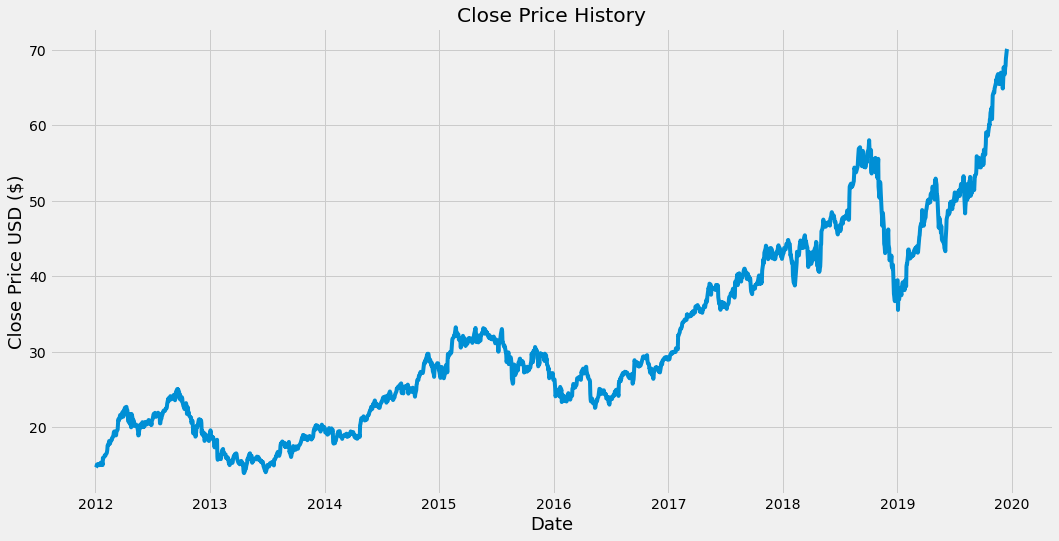

In [6]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [7]:
# A new numpy array with only the 'Close' column
data = df.filter(['Close'])
closeData = data.values # dataset

# Get the number of rows to train the model on
# Multiply 0.8 to take only 80% of it
training_data_len = math.ceil(len(closeData) * 0.8)

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closeData)
scaled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [9]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, : ]
# Split the data into x_train and y_train data sets
x_train = [] # independent training variables/training features
y_train = [] # dependent variables or target variables

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [10]:
# Convert the x_train and y_train to numpy arrays 
# so we can use them for training LSTM model

x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data as LSTM network expects the input to be 3D
# in the form of a number of samples, number of time steps
# and number of features

# The number of samples is equal to the number of rows x_train
# has which is 1543
# and the number of time steps is 60 (the number of columns)
# and the number of features is 1 (which is the closing price)
# hence (1543, 60, 1)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Build the LSTM model
model = Sequential()

# Add layer to LSTM model
# layer 50 neurons
# return_sequences = true as we will use another LSTM layer
# bc this is the very first layer, we need to give it
# a input shape which will be the number of time steps and the
# number of features

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))

# densly connected neural network layer with 25 neurons
model.add(Dense(25))
model.add(Dense(1))

In [13]:
# Compile the model
# Loss function is used to measure how well the model did on training
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
# Batch_size is the total number of training examples present
# in a single batch
# Epochs is the number of iterations when an entire dataset is
# passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 46s 28ms/step - loss: 0.0016


In [15]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to
# 2003 (the scaeled testing data set)

test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = closeData[training_data_len:,:] # all of the values that 
# we want our models to predict

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0]) # not scaled

In [16]:
# Convert the data to a numpy array (for LSTM model)
x_test = np.array(x_test)

In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the models predicted price values
predictions = model.predict(x_test) # we want this to be exactly the same as y_test data
predictions = scaler.inverse_transform(predictions) # we want this to contain the same
# values that are y_test data

In [19]:
# Get the root mean squared error (a.k.a RMSE)
# RMSE is a good measure of how accurate the model predicts the response and it's the
# standard deviation of the residuals
# The lower values of RMSE indicate a better fit
# Generally we evaluate the model with other metrics to get an idea of
# how well the model performs
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4905898666381836

<ipython-input-20-b6d9ffdcd7b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


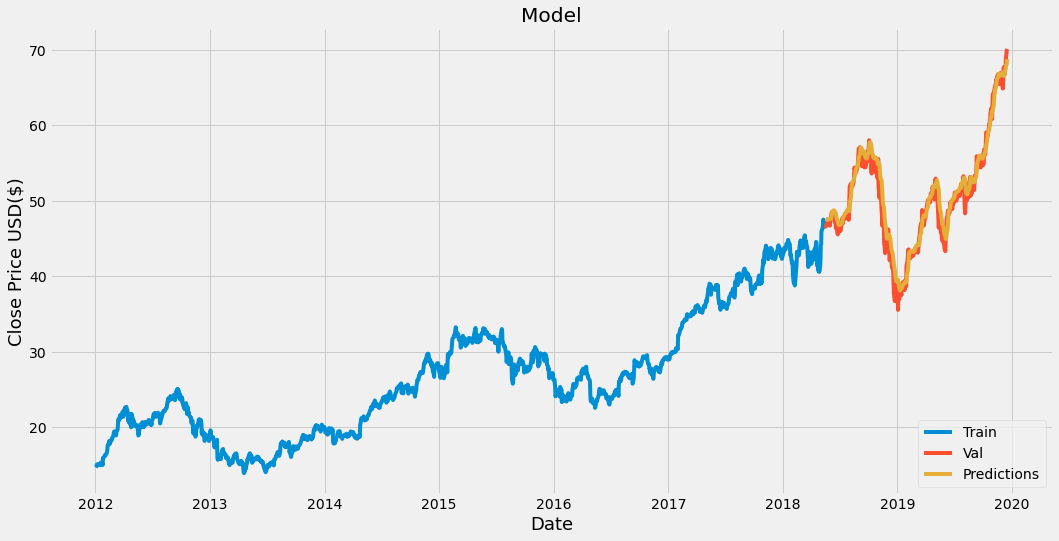

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close']) # closing price from training data
plt.plot(valid[['Close', 'Predictions']]) # actual price and predicted price
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,47.620556
2018-05-18,46.577499,47.601917
2018-05-21,46.907501,47.526680
2018-05-22,46.790001,47.492191
2018-05-23,47.090000,47.459641
...,...,...
2019-12-11,67.692497,67.248413
2019-12-12,67.864998,67.521599
2019-12-13,68.787498,67.799431


In [22]:
# Try predicting the closing price for Apple stock for 18th of December 2019
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

# Create a new dataframe
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled data
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[69.31918]]


In [23]:
# Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-17    70.102501
2019-12-18    69.934998
Name: Close, dtype: float64
